In [1]:
import pandas as pd
import numpy as np
from numpy import linalg as LA

import nltk
from nltk.tokenize import sent_tokenize,word_tokenize
#refer to https://www.kaggle.com/residentmario/sentiment-analysis-and-collocation-of-reviews
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import wordpunct_tokenize
import matplotlib.pyplot as plt

import gensim
from gensim.models.word2vec import LineSentence
from gensim.models import Word2Vec

import codecs

from nltk.stem import WordNetLemmatizer
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

import itertools as it
from gensim.models.phrases import Phrases, Phraser
import spacy #https://github.com/skipgram/modern-nlp-in-python/blob/master/executable/Modern_NLP_in_Python.ipynb

C:\Users\zzguk\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#read data and data cleanning
df_reviews = pd.read_csv('boston/reviews.csv')
df_reviews.head()

listing_id       id        date  reviewer_id reviewer_name  \
0     1178162  4724140  2013-05-21      4298113       Olivier   
1     1178162  4869189  2013-05-29      6452964     Charlotte   
2     1178162  5003196  2013-06-06      6449554     Sebastian   
3     1178162  5150351  2013-06-15      2215611        Marine   
4     1178162  5171140  2013-06-16      6848427        Andrew   

                                            comments  
0  My stay at islam's place was really cool! Good...  
1  Great location for both airport and city - gre...  
2  We really enjoyed our stay at Islams house. Fr...  
3  The room was nice and clean and so were the co...  
4  Great location. Just 5 mins walk from the Airp...

In [3]:
#there are several languages
#we only intereted in English
def get_language_likelihood(input_text):
    """Return a dictionary of languages and their likelihood of being the 
    natural language of the input text
    """
 
    input_text = input_text.lower()
    input_words = wordpunct_tokenize(input_text)
 
    language_likelihood = {}
    total_matches = 0
    for language in stopwords._fileids:
        language_likelihood[language] = len(set(input_words) &
                set(stopwords.words(language)))
 
    return language_likelihood
 
def get_language(input_text):
    """Return the most likely language of the given text
    """ 
    likelihoods = get_language_likelihood(input_text)
    return sorted(likelihoods, key=likelihoods.get, reverse=True)[0]

In [4]:
#drop na
df_reviews_no_na = df_reviews.dropna().copy() 

In [5]:
#create another columns for language
df_reviews_no_na['language'] = df_reviews_no_na['comments'].apply(get_language)

In [6]:
#this take a long time to run , we save it
df_reviews_no_na.to_csv('boston/reviews_no_na_add_language_type.csv',index=False)

In [3]:
df_reviews_lang = pd.read_csv('boston/reviews_no_na_add_language_type.csv')

In [8]:
#check how many types
df_reviews_lang['language'].value_counts()

english        64001
french          1285
arabic          1050
spanish          630
german           535
italian          191
dutch            184
portuguese       101
azerbaijani       99
danish            58
russian           27
swedish           18
norwegian         16
greek              8
romanian           7
finnish            5
hungarian          3
turkish            3
indonesian         1
Name: language, dtype: int64

In [4]:
#most are english, we only intereted in english
df_review_english = df_reviews_lang[df_reviews_lang['language']=='english'].copy()

In [5]:
#let's clean the data
#we will split each reviews into sentence and then words
#need to run  python -m spacy download en
nlp = spacy.load('C:\\Users\\zzguk\\Anaconda3\\Lib\\site-packages\\en_core_web_sm\\en_core_web_sm-2.0.0')

In [24]:
#put all txt together

sample_parsed_review = nlp(df_review_english['comments'][0])

In [25]:
print(sample_parsed_review)

My stay at islam's place was really cool! Good location, 5min away from subway, then 10min from downtown. The room was nice, all place was clean. Islam managed pretty well our arrival, even if it was last minute ;) i do recommand this place to any airbnb user :)


In [26]:
for num, sentence in enumerate(sample_parsed_review.sents):
    print('Sentence {}:'.format(num+1))
    print(sentence)
    print()

Sentence 1:
My stay at islam's place was really cool!

Sentence 2:
Good location, 5min away from subway, then 10min from downtown.

Sentence 3:
The room was nice, all place was clean.

Sentence 4:
Islam managed pretty well our arrival, even if it was last minute ;) i do recommand this place to any airbnb user :)



In [27]:
for num,entity in enumerate(sample_parsed_review.ents):
    print('Entity {}:'.format(num+1),entity,'-',entity.label_)

Entity 1: 5min - CARDINAL
Entity 2: 10min - CARDINAL
Entity 3: Islam - ORG
Entity 4: last minute - TIME


In [55]:
for token in sample_parsed_review:
    print(token.lemma_)

-PRON-
stay
at
islam
's
place
be
really
cool
!
good
location
,
5min
away
from
subway
,
then
10min
from
downtown
.
the
room
be
nice
,
all
place
be
clean
.
islam
manage
pretty
well
-PRON-
arrival
,
even
if
-PRON-
be
last
minute
;)
i
do
recommand
this
place
to
any
airbnb
user
:)


In [32]:
token_text = [token.orth_ for token in sample_parsed_review]
token_pos = [token.pos_ for token in sample_parsed_review]
list(zip(token_text,token_pos))

[('My', 'ADJ'),
 ('stay', 'NOUN'),
 ('at', 'ADP'),
 ('islam', 'NOUN'),
 ("'s", 'PART'),
 ('place', 'NOUN'),
 ('was', 'VERB'),
 ('really', 'ADV'),
 ('cool', 'ADJ'),
 ('!', 'PUNCT'),
 ('Good', 'ADJ'),
 ('location', 'NOUN'),
 (',', 'PUNCT'),
 ('5min', 'NOUN'),
 ('away', 'ADV'),
 ('from', 'ADP'),
 ('subway', 'NOUN'),
 (',', 'PUNCT'),
 ('then', 'ADV'),
 ('10min', 'VERB'),
 ('from', 'ADP'),
 ('downtown', 'NOUN'),
 ('.', 'PUNCT'),
 ('The', 'DET'),
 ('room', 'NOUN'),
 ('was', 'VERB'),
 ('nice', 'ADJ'),
 (',', 'PUNCT'),
 ('all', 'DET'),
 ('place', 'NOUN'),
 ('was', 'VERB'),
 ('clean', 'ADJ'),
 ('.', 'PUNCT'),
 ('Islam', 'PROPN'),
 ('managed', 'VERB'),
 ('pretty', 'ADV'),
 ('well', 'ADV'),
 ('our', 'ADJ'),
 ('arrival', 'NOUN'),
 (',', 'PUNCT'),
 ('even', 'ADV'),
 ('if', 'ADP'),
 ('it', 'PRON'),
 ('was', 'VERB'),
 ('last', 'ADJ'),
 ('minute', 'NOUN'),
 (';)', 'PUNCT'),
 ('i', 'PRON'),
 ('do', 'VERB'),
 ('recommand', 'ADV'),
 ('this', 'DET'),
 ('place', 'NOUN'),
 ('to', 'ADP'),
 ('any', 'DET'),
 (

In [33]:
token_entity_type = [token.ent_type_ for token in sample_parsed_review]
token_entity_iob = [token.ent_iob_ for token in sample_parsed_review]


In [35]:
tmp_list = list(zip(token_text, token_entity_type, token_entity_iob))
pd.DataFrame(tmp_list,
             columns=['token_text', 'entity_type', 'inside_outside_begin'])

token_text entity_type inside_outside_begin
0          My                                O
1        stay                                O
2          at                                O
3       islam                                O
4          's                                O
5       place                                O
6         was                                O
7      really                                O
8        cool                                O
9           !                                O
10       Good                                O
11   location                                O
12          ,                                O
13       5min    CARDINAL                    B
14       away                                O
15       from                                O
16     subway                                O
17          ,                                O
18       then                                O
19      10min    CARDINAL                    B
20       from                                O
21   downtown                                O
22          .                                O
23        The                                O
24       room                                O
25        was                                O
26       nice                                O
27          ,                                O
28        all                                O
29      place                                O
30        was                                O
31      clean                                O
32          .                                O
33      Islam         ORG                    B
34    managed                                O
35     pretty                                O
36       well                                O
37        our                                O
38    arrival                                O
39          ,                                O
40       even                                O
41         if                                O
42         it                                O
43        was                                O
44       last        TIME                    B
45     minute        TIME                    I
46         ;)                                O
47          i                                O
48         do                                O
49  recommand                                O
50       this                                O
51      place                                O
52         to                                O
53        any                                O
54     airbnb                                O
55       user                                O
56         :)                                O

In [38]:
token_lemma = [token.lemma_ for token in sample_parsed_review]
token_shape = [token.shape_ for token in sample_parsed_review]
pd.DataFrame(list(zip(token_text, token_lemma, token_shape)),
             columns=['token_text', 'token_lemma', 'token_shape'])

token_text token_lemma token_shape
0          My      -PRON-          Xx
1        stay        stay        xxxx
2          at          at          xx
3       islam       islam        xxxx
4          's          's          'x
5       place       place        xxxx
6         was          be         xxx
7      really      really        xxxx
8        cool        cool        xxxx
9           !           !           !
10       Good        good        Xxxx
11   location    location        xxxx
12          ,           ,           ,
13       5min        5min        dxxx
14       away        away        xxxx
15       from        from        xxxx
16     subway      subway        xxxx
17          ,           ,           ,
18       then        then        xxxx
19      10min       10min       ddxxx
20       from        from        xxxx
21   downtown    downtown        xxxx
22          .           .           .
23        The         the         Xxx
24       room        room        xxxx
25        was          be         xxx
26       nice        nice        xxxx
27          ,           ,           ,
28        all         all         xxx
29      place       place        xxxx
30        was          be         xxx
31      clean       clean        xxxx
32          .           .           .
33      Islam       islam       Xxxxx
34    managed      manage        xxxx
35     pretty      pretty        xxxx
36       well        well        xxxx
37        our      -PRON-         xxx
38    arrival     arrival        xxxx
39          ,           ,           ,
40       even        even        xxxx
41         if          if          xx
42         it      -PRON-          xx
43        was          be         xxx
44       last        last        xxxx
45     minute      minute        xxxx
46         ;)          ;)          ;)
47          i           i           x
48         do          do          xx
49  recommand   recommand        xxxx
50       this        this        xxxx
51      place       place        xxxx
52         to          to          xx
53        any         any         xxx
54     airbnb      airbnb        xxxx
55       user        user        xxxx
56         :)          :)          :)

In [40]:
token_entity_type = [token.ent_type_ for token in sample_parsed_review]
token_entity_iob = [token.ent_iob_ for token in sample_parsed_review]

pd.DataFrame(list(zip(token_text, token_entity_type, token_entity_iob)),
             columns=['token_text', 'entity_type', 'inside_outside_begin'])

token_text entity_type inside_outside_begin
0          My                                O
1        stay                                O
2          at                                O
3       islam                                O
4          's                                O
5       place                                O
6         was                                O
7      really                                O
8        cool                                O
9           !                                O
10       Good                                O
11   location                                O
12          ,                                O
13       5min    CARDINAL                    B
14       away                                O
15       from                                O
16     subway                                O
17          ,                                O
18       then                                O
19      10min    CARDINAL                    B
20       from                                O
21   downtown                                O
22          .                                O
23        The                                O
24       room                                O
25        was                                O
26       nice                                O
27          ,                                O
28        all                                O
29      place                                O
30        was                                O
31      clean                                O
32          .                                O
33      Islam         ORG                    B
34    managed                                O
35     pretty                                O
36       well                                O
37        our                                O
38    arrival                                O
39          ,                                O
40       even                                O
41         if                                O
42         it                                O
43        was                                O
44       last        TIME                    B
45     minute        TIME                    I
46         ;)                                O
47          i                                O
48         do                                O
49  recommand                                O
50       this                                O
51      place                                O
52         to                                O
53        any                                O
54     airbnb                                O
55       user                                O
56         :)                                O

In [41]:
token_attributes = [(token.orth_,
                     token.prob,
                     token.is_stop,
                     token.is_punct,
                     token.is_space,
                     token.like_num,
                     token.is_oov)
                    for token in sample_parsed_review]

df = pd.DataFrame(token_attributes,
                  columns=['text',
                           'log_probability',
                           'stop?',
                           'punctuation?',
                           'whitespace?',
                           'number?',
                           'out of vocab.?'])

df.loc[:, 'stop?':'out of vocab.?'] = (df.loc[:, 'stop?':'out of vocab.?']
                                       .applymap(lambda x: u'Yes' if x else u''))
                                               
df

text  log_probability stop? punctuation? whitespace? number?  \
0          My            -20.0                                          
1        stay            -20.0                                          
2          at            -20.0   Yes                                    
3       islam            -20.0                                          
4          's            -20.0                                          
5       place            -20.0                                          
6         was            -20.0   Yes                                    
7      really            -20.0   Yes                                    
8        cool            -20.0                                          
9           !            -20.0                Yes                       
10       Good            -20.0                                          
11   location            -20.0                                          
12          ,            -20.0                Yes                       
13       5min            -20.0                                          
14       away            -20.0                                          
15       from            -20.0   Yes                                    
16     subway            -20.0                                          
17          ,            -20.0                Yes                       
18       then            -20.0   Yes                                    
19      10min            -20.0                                          
20       from            -20.0   Yes                                    
21   downtown            -20.0                                          
22          .            -20.0                Yes                       
23        The            -20.0                                          
24       room            -20.0                                          
25        was            -20.0   Yes                                    
26       nice            -20.0                                          
27          ,            -20.0                Yes                       
28        all            -20.0   Yes                                    
29      place            -20.0                                          
30        was            -20.0   Yes                                    
31      clean            -20.0                                          
32          .            -20.0                Yes                       
33      Islam            -20.0                                          
34    managed            -20.0                                          
35     pretty            -20.0                                          
36       well            -20.0   Yes                                    
37        our            -20.0   Yes                                    
38    arrival            -20.0                                          
39          ,            -20.0                Yes                       
40       even            -20.0   Yes                                    
41         if            -20.0   Yes                                    
42         it            -20.0   Yes                                    
43        was            -20.0   Yes                                    
44       last            -20.0   Yes                                    
45     minute            -20.0                                          
46         ;)            -20.0                Yes                       
47          i            -20.0   Yes                                    
48         do            -20.0   Yes                                    
49  recommand            -20.0                                          
50       this            -20.0   Yes                                    
51      place            -20.0                                          
52         to            -20.0   Yes                                    
53        any            -20.0   Yes                               

In [6]:
def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    
    return token.is_punct or token.is_space

In [7]:
def punct_space_stop(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """
    
    return token.is_punct or token.is_space or token.is_stop

In [8]:

def lemmatized_sentence_corpus():
    for rev in df_review_english['comments']:
        parsed_rev = nlp(rev)
        for sent in parsed_rev.sents:
            yield u' '.join([token.lemma_ for token in sent 
                             if not punct_space_stop(token)])

In [9]:
#let's put all sentence into a file 
#it take some times
if False:
    with codecs.open('review_sentences_in_all_no_stop.txt','w',encoding='utf_8') as f:
        for sentence in lemmatized_sentence_corpus():
            f.write(sentence+'\n')

In [10]:
reveiw_sentences = LineSentence('review_sentences_in_all_no_stop.txt')

In [63]:
ct=0
for sent in reveiw_sentences:
    print(sent)
    ct += 1
    if ct>5:
        break

['-PRON-', 'stay', 'at', 'islam', "'s", 'place', 'be', 'really', 'cool']
['good', 'location', '5min', 'away', 'from', 'subway', 'then', '10min', 'from', 'downtown']
['the', 'room', 'be', 'nice', 'all', 'place', 'be', 'clean']
['islam', 'manage', 'pretty', 'well', '-PRON-', 'arrival', 'even', 'if', '-PRON-', 'be', 'last', 'minute', 'i', 'do', 'recommand', 'this', 'place', 'to', 'any', 'airbnb', 'user']
['great', 'location', 'for', 'both', 'airport', 'and', 'city', 'great', 'amenity', 'in', 'the', 'house', 'plus']
['islam', 'be', 'always', 'very', 'helpful', 'even', 'though', '-PRON-', 'be', 'away']


In [12]:
#write to a txt file
if False:
    bigram_model = Phrases(reveiw_sentences)
    bigram_model.save('bigram_review_all_no_stop')
bigram_model = Phrases.load('bigram_review_all_no_stop')

In [13]:
if False:
    with codecs.open('bigram_review_sentences_all_no_stop.txt','w',encoding='utf_8') as f:
        for sentence in reveiw_sentences:
            bigram_sent = u' '.join(bigram_model[sentence])
            f.write(bigram_sent + '\n')

C:\Users\zzguk\Anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [14]:
rev_bigram_sentences = LineSentence('bigram_review_sentences_all_no_stop.txt')

In [16]:
#let's do it again to get trigram and save the model
if False:
    trigram_model = Phrases(rev_bigram_sentences)
    trigram_model.save('trigram_review_all_no_stop')
trigram_model = Phrases.load('trigram_review_all_no_stop')

In [17]:
#let's save the trigram sentences
if False:
    with codecs.open('trigram_review_sentences_all_no_stop.txt','w',encoding='utf_8') as f:
        for sentence in rev_bigram_sentences:
            trigram_sent = u' '.join(trigram_model[sentence])
            f.write(trigram_sent + '\n')

In [18]:
rev_trigram_sentences = LineSentence('trigram_review_sentences_all_no_stop.txt')

In [45]:
#word2vector
if False:
    review_sentence2vec = Word2Vec(rev_trigram_sentences,size=100,window=5,
                                  min_count=20,sg=1,workers=4)
    review_sentence2vec.save('review_trigram_sentence_w2v_model_no_stop')
    
    #perform another 11 epochs of training
    for i in range(1,12):
        review_sentence2vec.train(rev_trigram_sentences,
                                  total_examples=review_sentence2vec.corpus_count,
                                  epochs=review_sentence2vec.iter)
        review_sentence2vec.save('review_trigram_sentence_w2v_model_no_stop')

review_sentence2vec = Word2Vec.load('review_trigram_sentence_w2v_model')
review_sentence2vec.init_sims()

print(u'{} training epochs so far.'.format(review_sentence2vec.train_count))

12 training epochs so far.


In [46]:
print(u'{:,} terms in the food2vec vocabulary.'.format(len(review_sentence2vec.wv.vocab)))

5,104 terms in the food2vec vocabulary.


In [21]:
review_sentence2vec.wv.most_similar(positive=['airport'],topn=10)

[('logan', 0.7502928972244263),
 ('blue_line', 0.7410403490066528),
 ('close_airport', 0.7400843501091003),
 ('logan_airport', 0.7153882384300232),
 ('airport_shuttle', 0.6539110541343689),
 ('south_station', 0.6310248374938965),
 ('shuttle', 0.5965450406074524),
 ('cab', 0.5728499293327332),
 ('train', 0.5672173500061035),
 ('free_shuttle', 0.5540308952331543)]

In [47]:
review_sentence2vec.wv.most_similar(positive=['airport'],topn=10)

[('logan_airport', 0.8081258535385132),
 ('logan', 0.7609093189239502),
 ('airport_shuttle', 0.7175217866897583),
 ('blue_line', 0.7128446102142334),
 ('south_station', 0.6744409799575806),
 ('train_station', 0.6678196787834167),
 ('train', 0.6494198441505432),
 ('bus_station', 0.6468003392219543),
 ('subway_station', 0.6281470060348511),
 ('red_line', 0.6235874891281128)]

In [22]:
review_sentence2vec.wv.most_similar(positive=['bed'],topn=10)

[('queen_bed', 0.7432321906089783),
 ('mattress', 0.735692024230957),
 ('master_bed', 0.6629842519760132),
 ('bed_pillow', 0.6531524658203125),
 ('soft', 0.6475930213928223),
 ('bed_comfy', 0.6447612047195435),
 ('sofa', 0.6421326398849487),
 ('futon', 0.635906457901001),
 ('bed_firm', 0.6321361064910889),
 ('memory_foam_mattress', 0.6314576864242554)]

In [48]:
review_sentence2vec.wv.most_similar(positive=['bed'],topn=10)

[('mattress', 0.7756842374801636),
 ('queen_bed', 0.7544865608215332),
 ('sofa_bed', 0.7341449856758118),
 ('sofa', 0.7092766761779785),
 ('couch', 0.7027804255485535),
 ('king_size_bed', 0.6978681087493896),
 ('futon', 0.6920413374900818),
 ('double_bed', 0.6893474459648132),
 ('queen_size_bed', 0.6831704378128052),
 ('soft', 0.6745144128799438)]

In [24]:
review_sentence2vec.wv.most_similar(positive=['tv'],topn=10)

[('tv_cable', 0.7676270008087158),
 ('cable', 0.7348117232322693),
 ('television', 0.7117252349853516),
 ('wifi', 0.6999471187591553),
 ('cable_tv', 0.6851332187652588),
 ('netflix', 0.6648626327514648),
 ('internet', 0.6388727426528931),
 ('channel', 0.6369379758834839),
 ('tv_channel', 0.6328471302986145),
 ('wireless_internet', 0.6210994720458984)]

In [49]:
review_sentence2vec.wv.most_similar(positive=['tv'],topn=10)

[('cable', 0.8065526485443115),
 ('television', 0.7724809646606445),
 ('netflix', 0.7711915373802185),
 ('internet', 0.7470119595527649),
 ('wifi', 0.7450128793716431),
 ('cable_tv', 0.7437824010848999),
 ('big_screen_tv', 0.71254563331604),
 ('wi_fi', 0.6935455799102783),
 ('desk', 0.6721540689468384),
 ('roku', 0.6653614640235901)]

In [25]:
review_sentence2vec.wv.most_similar(positive=['neighbor'],topn=10)

[('neighbour', 0.6053378582000732),
 ('loud_music', 0.5822433233261108),
 ('hear', 0.5501987934112549),
 ('yell', 0.5157263278961182),
 ('bothersome', 0.5132745504379272),
 ('highway', 0.5079926252365112),
 ('police', 0.49552446603775024),
 ('resident', 0.4933896064758301),
 ('nightclub', 0.4897192716598511),
 ('noisy', 0.4892547130584717)]

In [50]:
review_sentence2vec.wv.most_similar(positive=['neighbor'],topn=10)

[('neighbour', 0.7146357297897339),
 ('hear', 0.631752610206604),
 ('upstairs_neighbor', 0.5861818790435791),
 ('other_resident', 0.5729456543922424),
 ('loud', 0.5520524382591248),
 ('loud_music', 0.5497045516967773),
 ('noise', 0.5460641384124756),
 ('can_hear', 0.5417159795761108),
 ('other_tenant', 0.517612874507904),
 ('sound', 0.5099065899848938)]

In [26]:
review_sentence2vec.wv.most_similar(positive=['host'],topn=10)

[('hostess', 0.7204030752182007),
 ('gracious_host', 0.6924916505813599),
 ('hospitable', 0.6453973650932312),
 ('communicative', 0.6394771337509155),
 ('host-', 0.6157169342041016),
 ('attentive', 0.6017897725105286),
 ('welcoming', 0.599931538105011),
 ('easy_communicate', 0.5949435234069824),
 ('helpful', 0.5940340161323547),
 ('gracious', 0.5919612646102905)]

In [27]:
review_sentence2vec.wv.most_similar(positive=['boston'],topn=10)

[('city', 0.6288933753967285),
 ('town', 0.5953210592269897),
 ('cambridge', 0.5492438077926636),
 ('charlestown', 0.5470254421234131),
 ('back_bay', 0.5365704894065857),
 ('south_boston', 0.5361765623092651),
 ('jp', 0.5350315570831299),
 ('visit', 0.5291481018066406),
 ('beacon_hill', 0.5138571262359619),
 ('jamaica_plain', 0.5089597105979919)]

In [28]:
review_sentence2vec.wv.most_similar(positive=['jp'],topn=10)

[('jamaica_plain', 0.8597840070724487),
 ('jamaica_plains', 0.6965658068656921),
 ('centre_street', 0.6174668073654175),
 ('roslindale', 0.6071597337722778),
 ('mission_hill', 0.5675737261772156),
 ('brighton', 0.5547250509262085),
 ('boston', 0.5350315570831299),
 ('pond', 0.5170283913612366),
 ('jamaica_pond', 0.5118939876556396),
 ('arboretum', 0.5114830136299133)]

In [29]:
review_sentence2vec.wv.most_similar(positive=['bad'],topn=10)

[('terrible', 0.6471740007400513),
 ('fault', 0.5594987869262695),
 ('negative', 0.5556932091712952),
 ('dirty', 0.5101768374443054),
 ('disgusting', 0.506378173828125),
 ('uncomfortable', 0.501981258392334),
 ('unpleasant', 0.5010031461715698),
 ('complaint', 0.5003125071525574),
 ('downside', 0.49515148997306824),
 ('awful', 0.4928587079048157)]

In [30]:
review_sentence2vec.wv.most_similar(positive=['excellent'],topn=10)

[('great', 0.8225566148757935),
 ('fantastic', 0.7392227649688721),
 ('terrific', 0.6871085166931152),
 ('superb', 0.6785991191864014),
 ('wonderful', 0.6505728960037231),
 ('fabulous', 0.6392252445220947),
 ('outstanding', 0.6340883374214172),
 ('good', 0.632598876953125),
 ('phenomenal', 0.606070876121521),
 ('amazing', 0.5953195095062256)]

In [31]:
review_sentence2vec.wv.most_similar(positive=['close'],topn=10)

[('walk_distance', 0.7441684007644653),
 ('short_walk', 0.7417718172073364),
 ('near', 0.7242228984832764),
 ('walking_distance', 0.6946695446968079),
 ('short_walk_away', 0.6647159457206726),
 ('5_minute_walk', 0.6567593216896057),
 ('short_walking_distance', 0.653266429901123),
 ('convenient', 0.6525652408599854),
 ('literally_step', 0.6447298526763916),
 ('step_away', 0.6388636827468872)]

In [44]:
review_sentence2vec.wv.most_similar(positive=['wifi'],topn=10)

[('internet', 0.8207347989082336),
 ('wi_fi', 0.7948126792907715),
 ('tv', 0.6999471187591553),
 ('wireless_internet', 0.6638689041137695),
 ('wireless', 0.6431041359901428),
 ('cable', 0.6418042778968811),
 ('free_wifi', 0.6112637519836426),
 ('internet_connection', 0.6057960987091064),
 ('cable_tv', 0.593693733215332),
 ('internet_access', 0.5872415900230408)]

In [52]:
review_sentence2vec.wv.most_similar(positive=['wifi'],topn=10)

[('internet', 0.8818732500076294),
 ('wi_fi', 0.8181201815605164),
 ('tv', 0.7450128793716431),
 ('wireless', 0.7431336641311646),
 ('cable_tv', 0.7152531743049622),
 ('cable', 0.7140823602676392),
 ('internet_connection', 0.645317792892456),
 ('wireless_internet', 0.6249016523361206),
 ('netflix', 0.6093606948852539),
 ('apple_tv', 0.6078062057495117)]

In [32]:
words_embeding = review_sentence2vec.wv.syn0

C:\Users\zzguk\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  """Entry point for launching an IPython kernel.


In [33]:
words_embeding.shape

(5512, 100)

In [121]:
#get the words type

In [34]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

score:  0.026571788


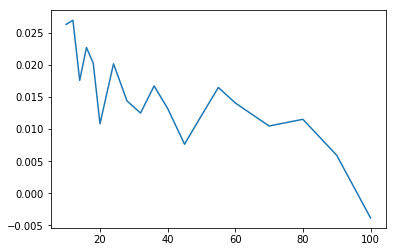

In [35]:
ncluster_list = [10,12,14,16,18,20,24,28,32,36,40,45,50,55,60,70,80,90,100]
scores=[]
for nclus in ncluster_list:
    km = KMeans(n_clusters=nclus,random_state=0)
    km.fit(words_embeding)
    predict = km.predict(words_embeding)
    scores.append(silhouette_score(words_embeding,predict))
plt.plot(ncluster_list,scores)

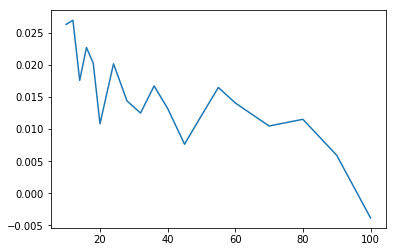

In [36]:
plt.plot(ncluster_list,scores)

In [37]:
km = KMeans(n_clusters=20,random_state=0)
km.fit(words_embeding)
cluster_centers = km.cluster_centers_
predict = km.predict(words_embeding)
print("score: ",silhouette_score(words_embeding,predict))

score:  0.01083504


In [38]:
cluster_centers[0]

array([ 0.09323099,  0.2188552 , -0.06405225,  0.3087411 , -0.25363347,
       -0.28486744, -0.10885674, -0.11815645, -0.2165378 , -0.01024014,
        0.08348683, -0.29681385, -0.21505113, -0.38267678, -0.21253507,
       -0.04844515, -0.541393  ,  0.13044423,  0.1074983 ,  0.10913371,
       -0.42992693, -0.03501263,  0.5621006 ,  0.10142583,  0.10188912,
       -0.0091757 , -0.16083266, -0.11360694, -0.1935935 , -0.5728536 ,
        0.18361364, -0.04023142,  0.24281138,  0.02401976,  0.22949593,
        0.28783476,  0.21666673,  0.354682  ,  0.3781676 , -0.15534884,
       -0.06661917, -0.0477869 ,  0.07953703,  0.07012437, -0.2637983 ,
       -0.01365041, -0.39439827, -0.16811767, -0.30761445, -0.13878164,
        0.30049792,  0.4451459 , -0.32125634,  0.19539371, -0.4919243 ,
       -0.3163066 , -0.2124438 , -0.3060941 ,  0.06291141, -0.09198045,
       -0.09617016,  0.09543853,  0.07178846, -0.23831904, -0.23363408,
       -0.18624854,  0.09896193,  0.3323601 ,  0.04047804,  0.12

In [39]:
array_index2words = np.array(review_sentence2vec.wv.index2word)

In [40]:
for i in range(20):
    words = array_index2words[predict==i]
    print("cluster ",i)
    print(words[0:10])

cluster  0
['provide' 'give' 'information' 'local' 'recommendation' 'show'
 'direction' 'instruction' 'tip' 'suggestion']
cluster  1
['breakfast' 'coffee' 'water' 'snack' 'delicious' 'fresh' 'treat' 'tea'
 'drink' 'coffee_tea']
cluster  2
['the' 'apartment' 'clean' 'nice' 'comfortable' 'perfect' 'quiet'
 'beautiful' 'lovely' 'very']
cluster  3
['host' 'helpful' 'friendly' 'accommodate' 'welcome' 'meet' 'sure'
 'responsive' 'communication' 'person']
cluster  4
['check' 'leave' 'arrive' 'arrival' 'key' 'let' 'wait' 'hour' 'when'
 'ready']
cluster  5
['look' 'airbnb' 'overall' 'expect' 'hotel' 'all' 'accommodation'
 'listing' 'price' 'rent']
cluster  6
['de' 'et' 'à' 'y' 'un' 'pour' 'la' 'en' 'très' 'le']
cluster  7
['room' 'bed' 'bathroom' 'space' 'small' 'bedroom' 'sleep' 'big' 'large'
 'living_room']
cluster  8
['kitchen' 'amenity' 'shower' 'towel' 'wifi' 'tv' 'extra' 'cook' 'fridge'
 'stock']
cluster  9
['issue' 'floor' 'light' 'window' 'noise' 'bad' 'basement' 'hear' 'stair'
 'dirty'

In [41]:
array_index2words[predict==2]

array(['the', 'apartment', 'clean', 'nice', 'comfortable', 'perfect',
       'quiet', 'beautiful', 'lovely', 'very', 'super', 'spacious',
       'excellent', 'amazing', 'cozy', 'fantastic', 'extremely',
       'everything', 'studio', 'awesome', 'describe', 'picture',
       'private', 'charming', 'cute', 'keep', 'condo', 'exactly_describe',
       'feel_home', 'exactly', 'incredibly', 'equip', 'modern', 'neat',
       'comfy', 'photo', 'description', 'appartment', 'perfectly', 'cosy',
       'feel_like_home', 'really', 'fabulous', 'gorgeous', 'bright',
       'decorate', 'advertise', 'appoint', 'incredible', 'facility',
       'terrific', 'clean_tidy', 'accurate', 'spotless', 'maintain',
       'warm_welcome', 'feel_right', 'organize', 'quaint', 'immaculate',
       'condition', 'tidy', 'bed_comfy', 'organized', 'like_picture',
       'exactly_picture', 'adorable', 'delightful', 'easily_accessible',
       'lay', 'charm', 'superb', 'furnished', 'confortable', 'decor',
       'style', '

In [42]:
for i in range(20):
    center = cluster_centers[i]
    smallest_i = 0
    smallest_r = 9999
    for j in range(len(words_embeding)):
        dist = center-words_embeding[j]
        r = np.mean(dist*dist)
        if r<smallest_r:
            smallest_r = r
            smallest_i = j
    print("cluster ",i)
    print("center word: "+array_index2words[smallest_i])
        

cluster  0
center word: information
cluster  1
center word: coffee
cluster  2
center word: clean
cluster  3
center word: host
cluster  4
center word: check
cluster  5
center word: -PRON-
cluster  6
center word: bien
cluster  7
center word: bed
cluster  8
center word: towel
cluster  9
center word: probably
cluster  10
center word: jason
cluster  11
center word: this_automate_posting
cluster  12
center word: this_automate_posting
cluster  13
center word: close
cluster  14
center word: t
cluster  15
center word: sarah
cluster  16
center word: ac
cluster  17
center word: this_automate_posting
cluster  18
center word: grocery_store
cluster  19
center word: -PRON-


In [176]:
review_sentence2vec.wv.most_similar(positive=['bed'],topn=10)

[('mattress', 0.7756842374801636),
 ('queen_bed', 0.7544865608215332),
 ('sofa_bed', 0.7341449856758118),
 ('sofa', 0.7092766761779785),
 ('couch', 0.7027804255485535),
 ('king_size_bed', 0.6978681087493896),
 ('futon', 0.6920413374900818),
 ('double_bed', 0.6893474459648132),
 ('queen_size_bed', 0.6831704378128052),
 ('soft', 0.6745144128799438)]

In [177]:
array_index2words[predict==0]

array(['bed', 'bathroom', 'kitchen', 'bedroom', 'sleep', 'big', 'large',
       'view', 'shower', 'wifi', 'living_room', 'window', 'tv', 'light',
       'hot', 'basement', 'huge', 'cold', 'relax', 'ac', 'fan', 'couch',
       'upstairs', 'sit', 'internet', 'dining', 'table', 'bath',
       'weather', 'watch', 'air_conditioning', 'summer', 'deck',
       'comfy_bed', 'c', 'desk', 'heat', 'private_bathroom', 'bonus',
       'hot_water', 'balcony', 'third_floor', 'separate', 'soft', 'air',
       'chair', 'air_conditioner', 'patio', 'sofa', 'air_mattress',
       'temperature', 'roof_deck', 'super_comfy', 'wi_fi', 'top_floor',
       'first_floor', 'cable', 'natural_light', 'feature', 'heater',
       'second_floor', 'netflix', 'porch', 'backyard', 'rooftop',
       'sofa_bed', '3rd_floor', 'water_pressure', 'sized', 'futon',
       'lounge', 'heating', 'sun', 'rooftop_deck', 'movie', 'double',
       'private_entrance', 'storage', 'air_condition', 'gym', 'roof',
       'cable_tv', 'priva

In [43]:
review_sentence2vec.wv.similarity('bed','wifi')

0.378947727737112

In [ ]:
#make a tag for each word
revi